In [ ]:

import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:

def show_images(images, cmap="viridis"):
    for img_path in images:
      img = cv2.imread(img_path)
      cv2_imshow(img)

In [ ]:
class ObjectFinder_v1:
    # def __init__(self, hsv_color_ranges=((0, 200),), min_saturation=127,
    #              min_value=100, min_sign_size=25, differential_rate=0.2):
    def __init__(self):
      self.minsize = 10

    def filter_signs_by_color(self, image):
        """Lọc các đối tượng màu đỏ và màu xanh dương - Có thể là biển báo.
            Ảnh đầu vào là ảnh màu BGR
        """
        # Chuyển ảnh sang hệ màu HSV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Lọc màu đỏ cho stop và biển báo cấm
        # lower1, upper1 = np.array([0, 70, 50]), np.array([10, 255, 255])
        lower1, upper1 = np.array([0, 100, 110]), np.array([179, 255, 255])

        lower2, upper2 = np.array([170, 70, 50]), np.array([180, 255, 255])
        mask_1 = cv2.inRange(image, lower1, upper1) # dải màu đỏ thứ nhất
        mask_2 = cv2.inRange(image, lower2, upper2) # dải màu đỏ thứ hai
        mask_r = cv2.bitwise_or(mask_1, mask_2) # kết hợp 2 kết quả từ 2 dải màu khác nhau

        # Lọc màu xanh cho biển báo điều hướng
        lower3, upper3 = np.array([85, 50, 200]), np.array([135, 250, 250])
        mask_b = cv2.inRange(image, lower3,upper3)

        # Kết hợp các kết quả
        mask_final  = cv2.bitwise_or(mask_r,mask_b)
        return mask_final


    def get_boxes_from_mask(self, img):
        """Tìm kiếm hộp bao biển báo
        """
        mask = self.filter_signs_by_color(img)
        bboxes = []

        nccomps = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
        numLabels, labels, stats, centroids = nccomps
        im_height, im_width = mask.shape[:2]
        for i in range(numLabels):
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            area = stats[i, cv2.CC_STAT_AREA]
            # Lọc các vật quá nhỏ, có thể là nhiễu
            if w < self.minsize or h < self.minsize:
                continue
            # Lọc các vật quá lớn
            if w > 0.8 * im_width or h > 0.8 * im_height:
                continue
            # Loại bỏ các vật có tỷ lệ dài / rộng quá khác biệt
            if w / h > 2.0 or h / w > 2.0:
                continue
            bboxes.append([x, y, w, h])
        return bboxes, mask

In [ ]:
class SignDetector_v1:
    def __init__(self, model):
        self.object_finder = ObjectFinder_v1()
        self.sign_classifier = model
        self.classes = ['unknown', 'left', 'no_left', 'right', 'no_right', 'straight', 'stop']

    def detect_traffic_signs(self, img):

        points, combined = self.object_finder.get_boxes_from_mask(img)

        # Preprocess
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img / 255.0

        # Classify signs using CNN
        signs = []
        for bbox in points:
            # Crop sign area
            x, y, w, h = bbox
            sub_image = img[y:y+h, x:x+w]

            if sub_image.shape[0] < 20 or sub_image.shape[1] < 20:
                continue

            # Preprocess
            sub_image = cv2.resize(sub_image, (32, 32))

            sub_image = np.expand_dims(sub_image, axis=0)

            # Use CNN to get prediction
            self.sign_classifier.setInput(sub_image)
            preds = self.sign_classifier.forward()
            preds = preds[0]
            cls = preds.argmax()
            score = preds[cls]

            if cls == 0 or score < 0.8:
              continue


            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            text = self.classes[cls] + ' ' + str(round(score, 2))
            cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            # Draw bounding box on the image
            # if cls != 0 and score >= 0.5:

            signs.append([self.classes[cls], x, y, w, h])

            # Store the result


        return signs, combined, img, points


classed:  [['no_right', 198, 65, 34, 38]]
points:  [[198, 65, 34, 38]]


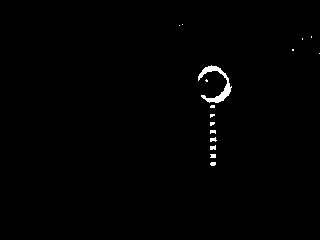

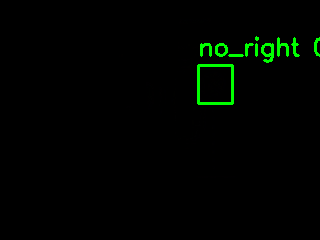

classed:  []
points:  [[141, 80, 11, 14]]


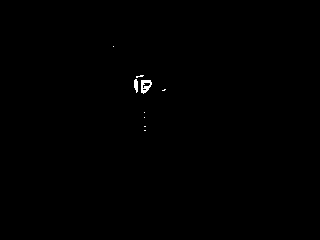

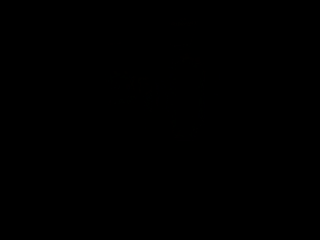

classed:  [['right', 202, 0, 65, 99]]
points:  [[202, 0, 65, 99], [39, 16, 15, 10]]


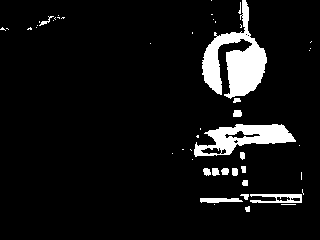

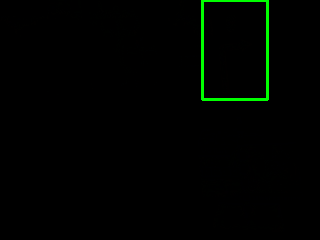

classed:  [['stop', 0, 44, 72, 58]]
points:  [[0, 44, 72, 58]]


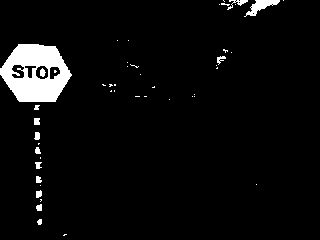

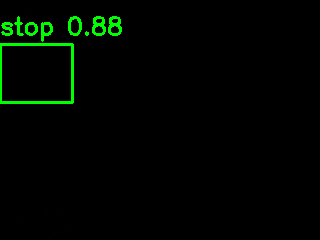

classed:  [['right', 258, 52, 45, 50]]
points:  [[258, 52, 45, 50]]


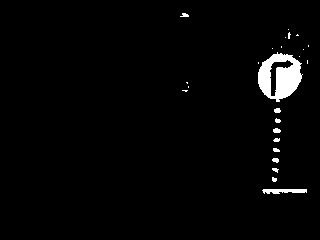

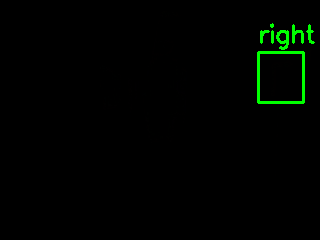

classed:  [['no_left', 212, 23, 64, 85]]
points:  [[212, 23, 64, 85], [233, 111, 10, 11], [230, 131, 12, 11], [231, 151, 10, 11], [229, 192, 10, 10], [227, 212, 10, 10]]


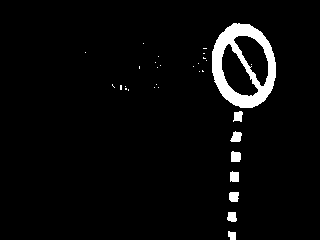

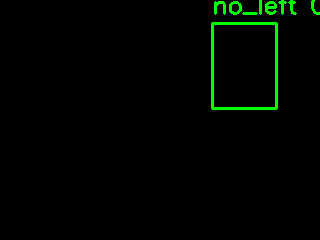

classed:  [['no_left', 80, 28, 80, 83]]
points:  [[80, 28, 80, 83]]


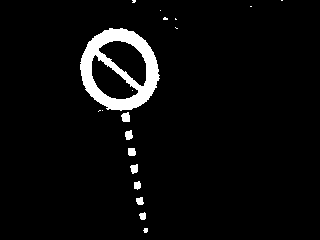

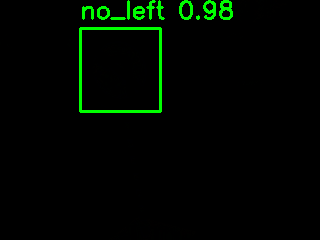

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from IPython.display import Image, display

# Specify the path to the uploaded image
image_path = "/content/images/00150.jpg"
traffic_sign_model = cv2.dnn.readNetFromONNX("/content/traffic_sign_classifier.onnx")

# display(Image(filename=image_path))
sign_detect = SignDetector_v1(traffic_sign_model)

for img_path in bgr_images:
      img = cv2.imread(img_path)
      # Load the image using OpenCV
      # img = cv2.imread(image_path)
      classed, combined, img, points = sign_detect.detect_traffic_signs(img)

      print("classed: ", classed)
      print("points: ", points)
      cv2_imshow(combined)
      cv2_imshow(img)

['/content/images/00020.jpg', '/content/images/00054.jpg', '/content/images/00339.jpg', '/content/images/00439.jpg', '/content/images/00003.jpg', '/content/images/00161.jpg', '/content/images/00514.jpg']


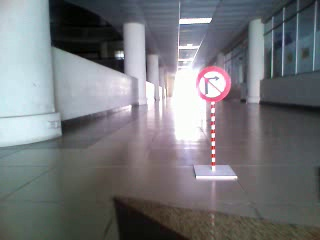

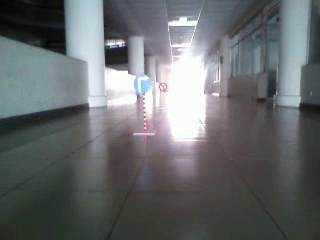

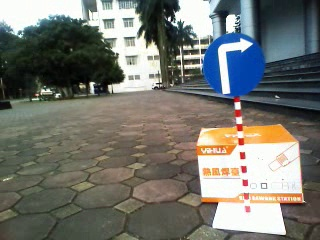

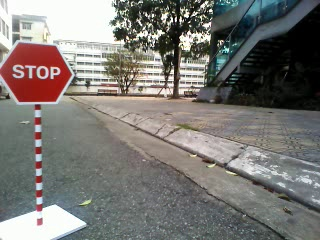

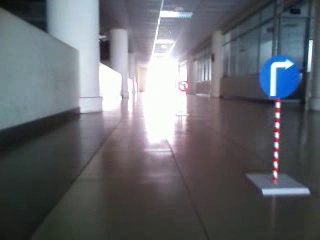

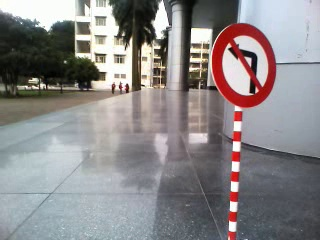

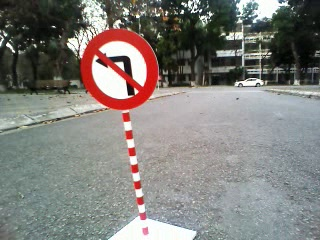

In [ ]:
# Đọc hình ảnh
import os

# Đường dẫn đến thư mục chứa hình ảnh
image_dir = '/content/images'
# Lấy danh sách tên tệp hình ảnh trong thư mục
bgr_images = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.jpg', '.png', '.jpeg'))]

# In danh sách tên tệp hình ảnh
print(bgr_images)
# bgr_images = [cv2.imread(str(name) + ".jpg") for name in image_names]
show_images(bgr_images)

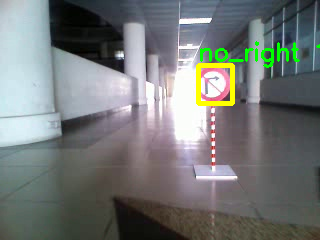

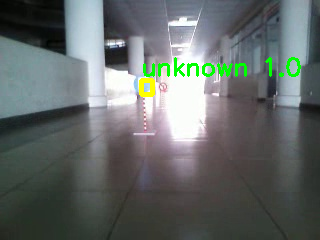

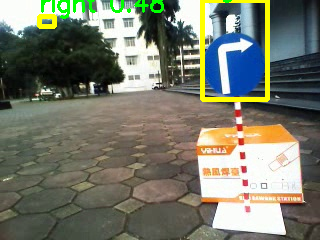

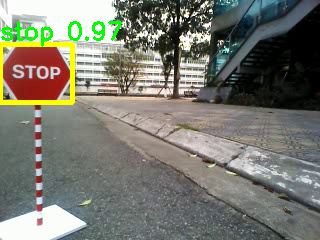

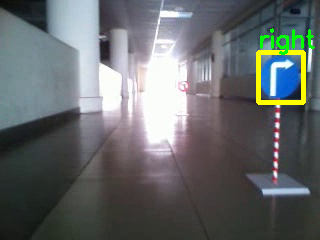

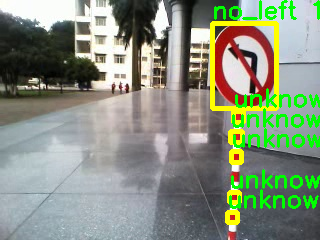

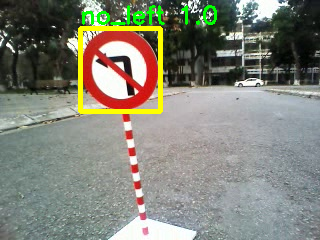

In [ ]:
# Nạp mô hình bằng OpenCV
model = cv2.dnn.readNetFromONNX("/content/traffic_sign_classifier_1.onnx")

def filter_signs_by_color(image):
    """Lọc các đối tượng màu đỏ và màu xanh dương - Có thể là biển báo.
        Ảnh đầu vào là ảnh màu BGR
    """
    # Chuyển ảnh sang hệ màu HSV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Lọc màu đỏ cho stop và biển báo cấm
    lower1, upper1 = np.array([0, 100, 110]), np.array([179, 255, 255])
    lower2, upper2 = np.array([170, 70, 50]), np.array([180, 255, 255])
    mask_1 = cv2.inRange(image, lower1, upper1) # dải màu đỏ thứ nhất
    mask_2 = cv2.inRange(image, lower2, upper2) # dải màu đỏ thứ hai
    mask_r = cv2.bitwise_or(mask_1, mask_2) # kết hợp 2 kết quả từ 2 dải màu khác nhau

    # Lọc màu xanh cho biển báo điều hướng
    lower3, upper3 = np.array([85, 50, 200]), np.array([135, 250, 250])
    mask_b = cv2.inRange(image, lower3,upper3)

    # Kết hợp các kết quả
    mask_final  = cv2.bitwise_or(mask_r,mask_b)
    return mask_final


def get_boxes_from_mask(mask):
    """Tìm kiếm hộp bao biển báo
    """
    bboxes = []

    nccomps = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    numLabels, labels, stats, centroids = nccomps
    im_height, im_width = mask.shape[:2]
    for i in range(numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        # Lọc các vật quá nhỏ, có thể là nhiễu
        if w < 10 or h < 10:
            continue
        # Lọc các vật quá lớn
        if w > 0.8 * im_width or h > 0.8 * im_height:
            continue
        # Loại bỏ các vật có tỷ lệ dài / rộng quá khác biệt
        if w / h > 2.0 or h / w > 2.0:
            continue
        bboxes.append([x, y, w, h])
    return bboxes


# Hàm phát hiện biển báo
def detect_traffic_signs(img, model, draw=None):
    """Phát hiện biển báo
    """

    # Các lớp biển báo
    classes = ['unknown', 'left', 'no_left', 'right',
               'no_right', 'straight', 'stop']

    # Phát hiện biển báo theo màu sắc
    mask = filter_signs_by_color(img)
    bboxes = get_boxes_from_mask(mask)

    # Tiền xử lý
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img / 255.0

    # Phân loại biển báo dùng CNN
    signs = []
    for bbox in bboxes:
        # Cắt vùng cần phân loại
        x, y, w, h = bbox
        sub_image = img[y:y+h, x:x+w]

        # if sub_image.shape[0] < 20 or sub_image.shape[1] < 20:
        #     continue

        # Tiền xử lý
        sub_image = cv2.resize(sub_image, (32, 32))
        sub_image = np.expand_dims(sub_image, axis=0)

        # Sử dụng CNN để phân loại biển báo
        model.setInput(sub_image)
        preds = model.forward()
        preds = preds[0]
        cls = preds.argmax()
        score = preds[cls]

        # Loại bỏ các vật không phải biển báo - thuộc lớp unknown
        # if cls == 0:
        #     continue

        # Loại bỏ các vật có độ tin cậy thấp
        # if score < 0.9:
        #     continue

        signs.append([classes[cls], x, y, w, h])

        # Vẽ các kết quả
        if draw is not None:
            text = classes[cls] + ' ' + str(round(score, 2))
            cv2.rectangle(draw, (x, y), (x+w, y+h), (0, 255, 255), 4)
            cv2.putText(draw, text, (x, y-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    return signs

# results = []
for img_path in bgr_images:
    img = cv2.imread(img_path)
    draw = img.copy()
    signs = detect_traffic_signs(img, model, draw=draw)
    # results.append(draw)
    cv2_imshow(draw)
# show_images(results)